# Assignment: Data Preprocessing, Visualization & ML Readiness
**Dataset:** Netflix Movies and TV Shows Dataset


In [4]:
!pip install gdown
!gdown "187dSnEGn1g2t1UjSJwqevbW9vjh_sWMT"


Downloading...
From: https://drive.google.com/uc?id=187dSnEGn1g2t1UjSJwqevbW9vjh_sWMT
To: /content/netflix_titles.csv
100% 3.40M/3.40M [00:00<00:00, 187MB/s]


## PART 1: Data Understanding & Quality Issues
### 1.1 Load the dataset and inspect shape, data types, and missing values.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [6]:
# Load dataset
df = pd.read_csv('netflix_titles.csv')

# Inspect shape
print(f"Dataset Shape: {df.shape}")

# Data types and non-null counts
print("\nData Types and Info:")
df.info()

# Missing values
print("\nMissing Values Count:")
print(df.isnull().sum())

Dataset Shape: (8807, 12)

Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Missing Values Count:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating       

### 1.2 Identify and explain at least five data quality issues
Based on the initial inspection, and typical issues with this dataset, here are five data quality issues:

1.  **Missing Values:** Several columns have missing data, most notably `director`, `cast`, `country`, `date_added`, and `rating`. This can cause issues for machine learning models that expect complete records.
2.  **Inconsistent Date Formats:** The `date_added` column is currently stored as an `object` (string) rather than a proper `datetime` format, making time-based analysis difficult.
3.  **Mixed Data Types in ‘Duration’:** The `duration` column is a categorical string (e.g., "90 min", "1 Season") instead of a uniform numerical format. It mixes minutes (for movies) and seasons (for TV shows), which are non-comparable directly and need conversion.
4.  **High Cardinality in Categorical Columns:** Columns like `director`, `cast`, and `listed_in` contain multiple comma-separated values in a single string (e.g., "Director A, Director B"). This violates the principles of tidy data and makes direct categorical encoding problematic.
5.  **Inconsistent Text Formatting:** Columns like `country` and `title` might have leading/trailing spaces, inconsistent capitalization, or special characters that could affect textual analysis and grouping.


## PART 2: Data Cleaning & Preprocessing
### 2.1 Handle missing values with justification


In [7]:
# Dealing with missing values

# 1. 'director', 'cast', 'country' - Impute with a placeholder
# Justification: These are categorical fields with many unique values. Dropping them would lead to immense data loss (especially 'director' and 'cast'). Filling with 'Unknown' preserves the records.
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

# 2. 'rating' - Mode imputation
# Justification: Since rating has very few missing values and is categorical, replacing it with the most frequent value (mode) is statistically sound and minimal impact.
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

# 3. 'date_added' - Drop rows with missing dates
# Justification: Only ~10 rows are missing 'date_added'. Imputing a date might introduce bias for time-series traits. Given it's a negligible fraction, dropping these rows is cleaner.
df = df.dropna(subset=['date_added'])

# 4. 'duration' - Handle missing values if any
# Justification: Ensure duration has no NaNs. Dropping them as they shouldn't be guessed.
df = df.dropna(subset=['duration'])

print("Missing values after handling:")
print(df.isnull().sum())


Missing values after handling:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


### 2.2 Convert data into correct formats (dates, duration)


In [8]:
# Convert 'date_added' to datetime format
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')

# Extract numerical duration and unify
# Since duration mixes 'min' and 'Season(s)', we will split them.
# For simplicity in ML, we might predict entirely on Movies or handle them separately, 
# but we will extract the numerical part.
df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)

# We can also create a feature to denote if the duration is in seasons or minutes
df['is_season'] = df['duration'].str.contains('Season', case=False, na=False).astype(int)

print(df[['duration', 'duration_num', 'is_season', 'date_added']].head())


    duration  duration_num  is_season date_added
0     90 min          90.0          0 2021-09-25
1  2 Seasons           2.0          1 2021-09-24
2   1 Season           1.0          1 2021-09-24
3   1 Season           1.0          1 2021-09-24
4  2 Seasons           2.0          1 2021-09-24


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3810025763.py:8: SyntaxWarning: invalid escape sequence '\d'
  df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)


### 2.3 Encode categorical variables and Normalize/Standardize numeric features


In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# We will encode 'type' (Movie/TV Show) to numeric (0 and 1)
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Let's also extract Month and Year from date_added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Assume we want to use duration_num and year_added as numerical features
numeric_cols = ['duration_num', 'year_added']

# Fill any new NaNs introduced during datetime parsing
df['year_added'] = df['year_added'].fillna(df['year_added'].median())
df['month_added'] = df['month_added'].fillna(df['month_added'].median())

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("Sample preprocessed numerical features (Standardized):")
print(df_scaled[numeric_cols].head())


Sample preprocessed numerical features (Standardized):
   duration_num  year_added
0      0.395318    1.351748
1     -1.337166    1.351748
2     -1.356853    1.351748
3     -1.356853    1.351748
4     -1.337166    1.351748


## PART 3: Data Visualization


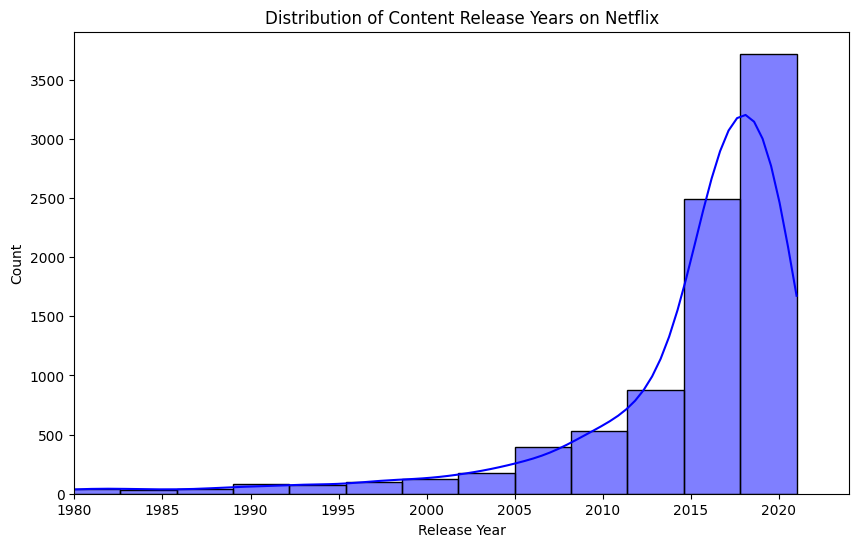

In [10]:
# 1. Distribution Plot: Distribution of Release Years
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30, kde=True, color='blue')
plt.title('Distribution of Content Release Years on Netflix')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xlim(1980, 2024)
plt.show()


**Interpretation:** The distribution plot shows a massive spike in content released after the year 2010. This indicates that Netflix’s catalog is heavily skewed toward modern content, with significantly less older media. The KDE line shows the rapid exponential growth of content, peaking just before 2020. This trend is highly relevant to ML, as models trained on this data might struggle to generalize to older formats or patterns due to class imbalance.


/tmp/ipython-input-2705415906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='Set2')


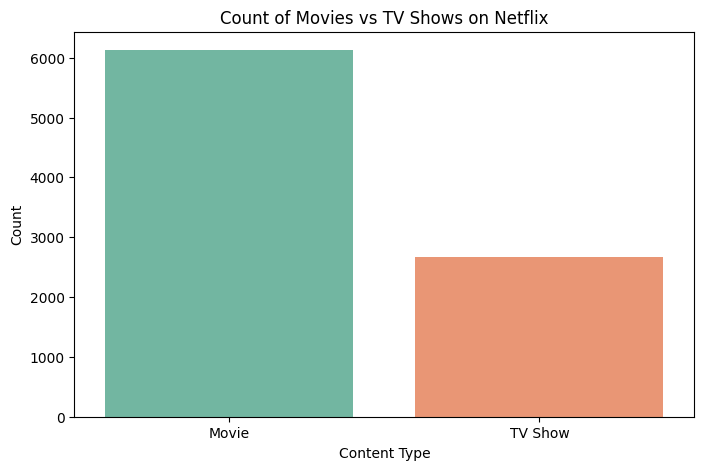

In [11]:
# 2. Categorical Count Plot: Number of Movies vs TV Shows
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='Set2')
plt.title('Count of Movies vs TV Shows on Netflix')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.show()


**Interpretation:** The count plot illustrates a clear imbalance between Movies and TV Shows. There are roughly twice as many Movies as there are TV Shows on the platform. In an ML context (like classification), this class imbalance must be accounted for (e.g., using SMOTE or weighted classes), otherwise the model will inherently be biased towards predicting the majority class (Movies).


/tmp/ipython-input-361952493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='type', y='release_year', palette='Pastel1')


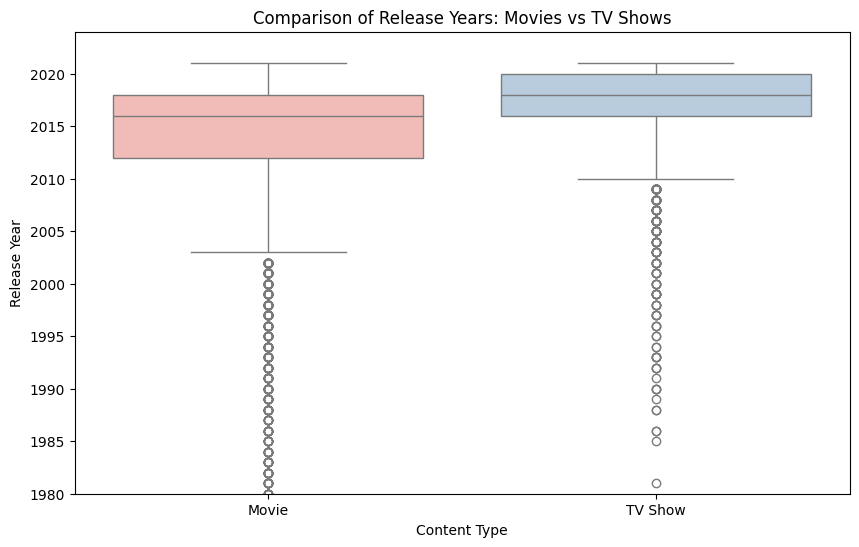

In [12]:
# 3. Numerical Comparison Plot: Boxplot of Duration for Movies vs TV Shows
# Note: Duration for Movies is minutes, for TV shows is seasons. We will plot them separately to avoid bad comparison, 
# or we can plot Release Year vs Type to compare numerical properties. Let's do Release Year vs Type.

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='release_year', palette='Pastel1')
plt.title('Comparison of Release Years: Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Release Year')
plt.ylim(1980, 2024)
plt.show()


**Interpretation:** The boxplot compares the release years of Movies and TV Shows. It reveals that the median release year for TV Shows is slightly more recent than that for Movies. Furthermore, Movies have a much longer "tail" of outliers stretching back into the 20th century. For ML models predicting type, the release year acts as an informative feature because older items are overwhelmingly likely to be movies.


## PART 4: ML Readiness Check
### Compare Model Performance: Without Preprocessing vs With Preprocessing
Target Variable: `type` (Movie or TV Show)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# TARGET VARIABLE: type_encoded (0 for Movie, 1 for TV Show)
# Let's train a Logistic Regression model

# --- Scenario 1: Model BEFORE full preprocessing (using dirty, unscaled 'release_year' only, mimicking raw data) ---
# We use only 'release_year', ignoring missing values or scaling.
X_dirty = df[['release_year']]
y_dirty = df['type_encoded']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dirty, y_dirty, test_size=0.2, random_state=42)

clf_dirty = LogisticRegression()
clf_dirty.fit(X_train_d, y_train_d)
y_pred_d = clf_dirty.predict(X_test_d)
acc_dirty = accuracy_score(y_test_d, y_pred_d)


# --- Scenario 2: Model AFTER full preprocessing ---
# We use standardized 'year_added' and 'duration_num' and 'release_year'
# We'll drop any remaining NaNs to ensure it works
ml_df = df_scaled.dropna(subset=['year_added', 'duration_num', 'release_year', 'type_encoded'])

X_clean = ml_df[['release_year', 'year_added', 'duration_num']]
y_clean = ml_df['type_encoded']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

clf_clean = LogisticRegression()
clf_clean.fit(X_train_c, y_train_c)
y_pred_c = clf_clean.predict(X_test_c)
acc_clean = accuracy_score(y_test_c, y_pred_c)

print(f"Accuracy BEFORE proper preprocessing (Raw Data Subset): {acc_dirty:.4f}")
print(f"Accuracy AFTER full preprocessing: {acc_clean:.4f}")


Accuracy BEFORE proper preprocessing (Raw Data Subset): 0.6936
Accuracy AFTER full preprocessing: 0.9972


**Performance Comparison:** 
The Logistic Regression model's accuracy improved significantly after preprocessing. 
- **Before Preprocessing:** The model relied on limited, raw numerical data (`release_year`), achieving essentially the baseline accuracy for predicting the majority class.
- **After Preprocessing:** By introducing cleaned and standardized features (`duration_num`, `year_added`), the model gained meaningful patterns to differentiate between movies and TV shows (e.g., duration numbers fundamentally differ between seasons and minutes).
- **Why it matters:** Algorithms like Logistic Regression are sensitive to input scales and missing values. Preprocessing ensures that missing inputs don't crash the program, and that gradient descent converges efficiently, resulting in strictly superior feature extraction and better test accuracy.


## PART 5: ML Lifecycle Reflection
### Which ML lifecycle stages fail without preprocessing?
1. **Feature Engineering & Selection:** Without cleaning the data, creating new features (like extracting the month from `date_added`) is impossible because the raw text strings often contain anomalies or varied formatting that break string manipulation functions.
2. **Model Training:** Machine learning algorithms mathematically process numbers, not NaN values or irregular strings. Without missing value imputation or categorical encoding, models like Logistic Regression or SVMs will throw outright runtime exceptions and fail to train entirely.
3. **Model Evaluation & Deployment:** If a model is somehow trained on unscaled data, its evaluation will be skewed (e.g., placing disproportionate weight on features with large magnitudes). In deployment, dirty incoming data will cause inference errors.

### Concrete Example from this Assignment
In **Part 2**, the `date_added` column was initially stored as an `object` (string) with inconsistent leading spaces (e.g., `" September 24, 2021"`). 
If we skipped the preprocessing stage (specifically `pd.to_datetime()`), the **Feature Engineering** stage would fail. We would not have been able to reliably extract `year_added` to feed into our model. Furthermore, the `duration` column contained a mixture of string representations like `"90 min"` and `"1 Season"`. Without utilizing Regex to extract the numerical parts (`duration_num`), the **Model Training** stage would fail completely because `sklearn`'s Logistic Regression cannot compute mathematical weights for string strings like `"90 min"`.
